# GoogLeNet

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import d2l.torch as d2l

$Inception$ 块

![fig](https://zh-v2.d2l.ai/_images/inception.svg)

相当于使用了不同的滤波器的 $size$ 来探索图像的细节

$Inception$ 块相比于 $3\times 3$ 或者 $5\times 5$ 的卷积层来说, 有更少的参数个数和计算复杂度

In [2]:
class Inception(nn.Module):
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)
    def forward(self, X):
        p1 = F.relu(self.p1_1(X))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(X))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(X))))
        p4 = F.relu(self.p4_2(self.p4_1(X))) # 汇聚层不需要 ReLU
        return torch.cat((p1, p2, p3, p4), dim=1) # 在 output_channel 上堆叠

### 逐步实现 GoogLeNet

![fig2](img/fig2.png)

#### stage 1 & 2

![stage12](img/stage1%262.png)

$stage$ $1$ 当中的两个层分别对输入图像进行了一个高宽减半的操作, 所以就是高宽缩小了 $4$ 倍,  在这里先进行 $padding$ 然后设置 $stride=2$ 高宽就减半了

$stage$ $2$ 中, 先是用一个 $1\times 1$ 的 $kernel$ 进行全连接, 再使用一个 $3\times 3$ 的卷积层增大通道数, 这两个层都不改变图像的 $size$, 最后用一个最大池化层来完成高宽减半

In [3]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)
b2 = nn.Sequential(
    nn.Conv2d(64, 64, kernel_size=1), nn.ReLU(),
    nn.Conv2d(64, 192, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

#### stage 3

![stage3](img/stage3.png)

$stage$ $3$ 中, 使用了两个 $Inception$ 块, $Inception$ 块不改变图像的 $size$ , 最后还是由池化层来压缩图像的 $size$

![pross](img/process.png)

这幅图展示了输入的参数 , 最后一组数据加起来就是输出的 $channel$ , $64+128+32+32=256$

In [4]:
b3 = nn.Sequential(
    Inception(192, 64, (96, 128), (16, 32), 32),
    Inception(256, 128, (128, 192), (32, 96), 64),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

#### stage 4 & 5

![stage45](img/stage4%265.png)

$Inception$ 参数变化看 $stage$ $3$ , $stage$ $4$ 和 $5$ 是一堆 $Inception$ 堆叠 , 最后通过一个全局池化层输出

In [5]:
b4 = nn.Sequential(
    Inception(480, 192, (96, 208), (16, 48), 64),
    Inception(512, 160, (112, 224), (24, 64), 64),
    Inception(512, 128, (128, 256), (24, 64), 64),
    Inception(512, 112, (144, 288), (32, 64), 64),
    Inception(528, 256, (160, 320), (32, 128), 128),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)
b5 = nn.Sequential(
    Inception(832, 256, (160, 320), (32, 128), 128),
    Inception(832, 384, (192, 384), (48, 128), 128),
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten()
)

In [6]:
net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

In [7]:
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape : \t', X.shape)

Sequential output shape : 	 torch.Size([1, 64, 24, 24])
Sequential output shape : 	 torch.Size([1, 192, 12, 12])
Sequential output shape : 	 torch.Size([1, 480, 6, 6])
Sequential output shape : 	 torch.Size([1, 832, 3, 3])
Sequential output shape : 	 torch.Size([1, 1024])
Linear output shape : 	 torch.Size([1, 10])


In [8]:
learning_rate, num_epochs, batch_size = 0.05, 25, 64
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)

$cost$ $14m57.2s$

loss 0.101, train acc 0.961, test acc 0.913
1961.3 examples/sec on cuda:0


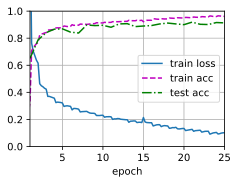

In [9]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, learning_rate, d2l.try_gpu(), ylim=[0.0, 1.0])

$cost$ $8m51.8s$

loss 0.431, train acc 0.838, test acc 0.722
2766.8 examples/sec on cuda:0


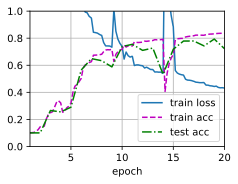

In [19]:
learning_rate, num_epochs, batch_size = 0.02, 20, 512
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, learning_rate, d2l.try_gpu(), ylim=[0.0, 1.0])

$cost$ $10m56.7s$

loss 0.243, train acc 0.908, test acc 0.877
2169.8 examples/sec on cuda:0


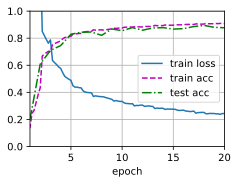

In [20]:
learning_rate, num_epochs, batch_size = 0.02, 20, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, learning_rate, d2l.try_gpu(), ylim=[0.0, 1.0])

$cost$ $33m23.3s$

loss 0.163, train acc 0.939, test acc 0.921
325.1 examples/sec on cuda:0


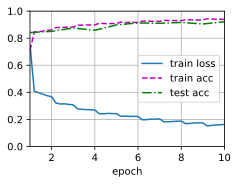

In [21]:
learning_rate, num_epochs, batch_size = 0.02, 10, 8
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, learning_rate, d2l.try_gpu(), ylim=[0.0, 1.0])

$cost$ $21m59.2s$

loss 0.269, train acc 0.897, test acc 0.882
2897.8 examples/sec on cuda:0


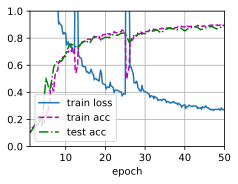

In [26]:
learning_rate, num_epochs, batch_size = 0.05, 50, 1000
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, learning_rate, d2l.try_gpu(), ylim=[0.0, 1.0])

低的 $batch\_size$ 会导致 $GPU$ 的并行度变差, 也就是运行速度会变得非常的慢

$batch\_size$ 变低的时候, 会进行更多次的更新, 所以在曲线上来看下降的更快, 因为每一个 $mini$ $batch$ 都会对所有的参数进行一次更新, 更新了很多次, 虽然可能走了很多的弯路, 但是由于走了很多步, 所以最后的图像看起来比较规整, 都是呈下降趋势, 而 $batch\_size$ 很大的时候看起来曲线很抖是因为更新的次数少了, 弯弯曲曲走的都在 $epoch$ - $loss$ 曲线中体现出来了

$batch\_size$ 小不是一件坏事, 这样使用的显存更小, 小的 $batch\_size$ 会对网络产生更多的噪声, 这对神经网络来说是一件好事